# Posterior Predictive Checks (PPC) in SBI

A common **safety check** performed as part of inference are [Posterior Predictive Checks (PPC)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/rssa.12378). A PPC compares data $x_{\text{pp}}$ generated using the parameters $\theta_{\text{posterior}}$ sampled from the posterior with the observed data $x_o$. The general concept is that -if the inference is correct- **the generated data $x_{\text{pp}}$ should "look similar" to the oberved data $x_0$**. Said differently, $x_o$ should be within the support of $x_{\text{pp}}$.

A PPC usually should not be used as a [validation metric](http://proceedings.mlr.press/v130/lueckmann21a.html). Nonetheless a PPC is a good start for an inference diagnosis and can provide an intuition about any bias introduced in inference: does $x_{\text{pp}}$ systematically differ from $x_o$?

## Conceptual Code for PPC

The following illustrates the main approach of PPCs. We have a trained neural posterior and want to check the correlation between the observation(s) $x_o$ and the posterior sample(s) $x_{\text{pp}}$.

```python
from sbi.analysis import pairplot

# A PPC is performed after we trained a neural posterior `posterior`
posterior.set_default_x(x_o) # x_o loaded from disk for example

# We draw theta samples from the posterior. This part is not in the scope of SBI
posterior_samples = posterior.sample((5_000,))

# We use posterior theta samples to generate x data
x_pp = simulator(posterior_samples)

# We verify if the observed data falls within the support of the generated data
_ = pairplot(
    samples=x_pp,
    points=x_o
)
```

## Performing a PPC of a toy example

Below we provide an example Posterior Predictive Check (PPC) of some toy example:

In [1]:
import torch

from sbi.analysis import pairplot

_ = torch.manual_seed(0)

We work on an inference problem over three parameters using any of the techniques implemented in `sbi`. In this tutorial, we load the dummy posterior (from a python module `toy_posterior_for_07_cc` alongside this notebook):

In [2]:
from toy_posterior_for_07_cc import ExamplePosterior

posterior = ExamplePosterior()

Let us say that we are observing the data point $x_o$:

In [3]:
D = 5  # simulator output was 5-dimensional
x_o = torch.ones(1, D)
posterior.set_default_x(x_o)

The posterior can be used to draw $\theta_{\text{posterior}}$ samples:

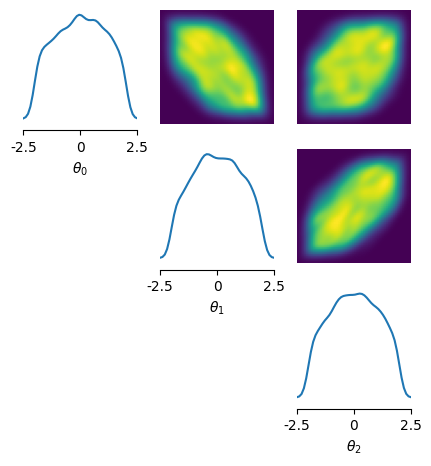

In [4]:
posterior_samples = posterior.sample((5_000,))

fig, ax = pairplot(
    samples=posterior_samples,
    limits=torch.tensor([[-2.5, 2.5]] * 3),
    upper=["kde"],
    diag=["kde"],
    figsize=(5, 5),
    labels=[rf"$\theta_{d}$" for d in range(3)],
)

Now we can use our simulator to generate some data $x_{\text{PP}}$. We will use the poterior samples $\theta_{\text{posterior}}$ as input parameters. Note that the simulation part is not in the `sbi` scope, so any simulator -including a non-Python one- can be used at this stage. In our case we'll use a dummy simulator for the sake of demonstration:

In [5]:
def dummy_simulator(theta: torch.Tensor, *args, **kwargs) -> torch.Tensor:
    """ a function performing a simulation emulating a real simulator outside sbi

    Args:
        theta: parameters to control the simulation (in this tutorial,
            these are the posterior_samples $\theta_{\text{posterior}}$ obtained
            from the trained posterior.
        args: parameters
        kwargs: keyword arguments
    """

    sample_size = theta.shape[0] # number of posterior_samples
    scale = 1.0

    shift = torch.distributions.Gumbel(loc=torch.zeros(D), scale=scale / 2).sample()
    return torch.distributions.Gumbel(loc=x_o[0] + shift, scale=scale).sample(
        (sample_size,)
    )


x_pp = dummy_simulator(posterior_samples)

Plotting $x_o$ against the $x_{\text{pp}}$, we perform a PPC that represents a sanity check. In this case, the check indicates that $x_o$ falls right within the support of $x_{\text{pp}}$, which should make the experimenter rather confident about the estimated `posterior`:

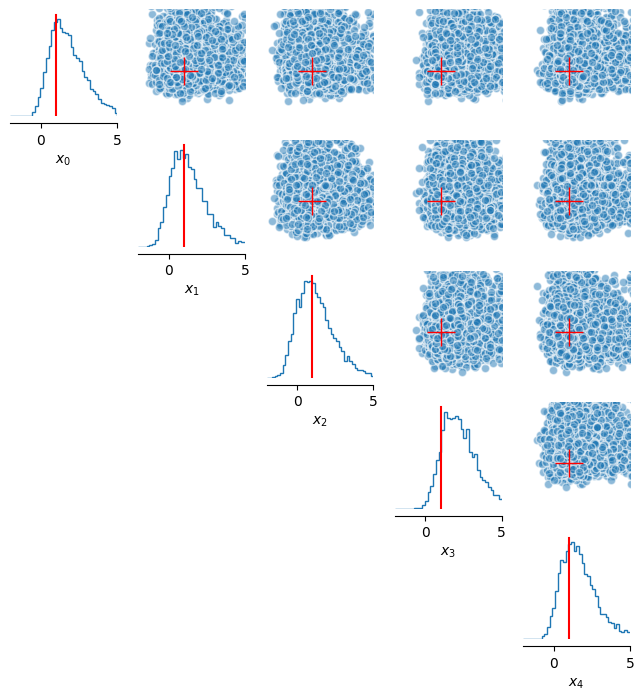

In [6]:
_ = pairplot(
    samples=x_pp,
    points=x_o[0],
    limits=torch.tensor([[-2.0, 5.0]] * 5),
    figsize=(8, 8),
    upper="scatter",
    upper_kwargs=dict(marker=".", s=5),
    fig_kwargs=dict(
        points_offdiag=dict(marker="+", markersize=20),
        points_colors="red",
    ),
    labels=[rf"$x_{d}$" for d in range(D)],
)

In contrast, $x_o$ falling well outside the support of $x_{\text{pp}}$ is indicative of a failure to estimate the correct posterior. Here we simulate such a failure mode (by introducing a constant shift to the observations, which the neural estimator was not trained on):

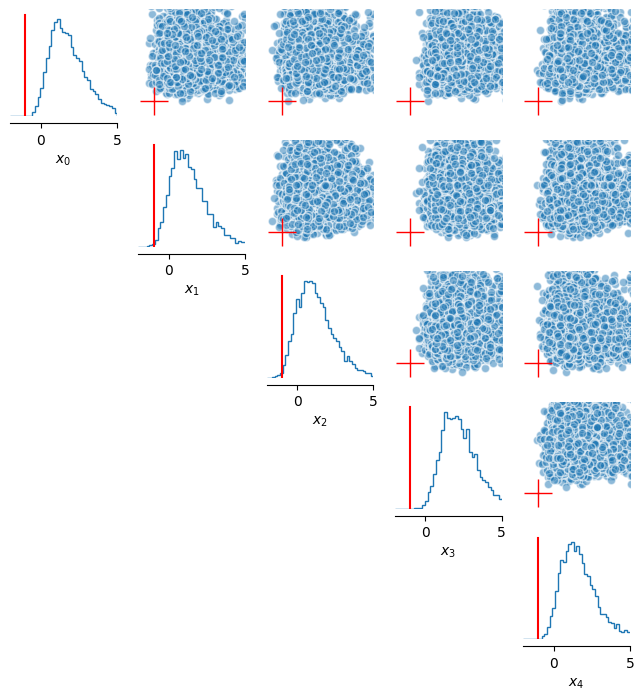

In [7]:
error_shift = -2.0 * torch.ones(1, 5)

_ = pairplot(
    samples=x_pp,
    points=x_o[0] + error_shift, # shift the observations
    limits=torch.tensor([[-2.0, 5.0]] * 5),
    figsize=(8, 8),
    upper="scatter",
    upper_kwargs=dict(marker=".", s=5),
    fig_kwargs=dict(
        points_offdiag=dict(marker="+", markersize=20),
        points_colors="red",
    ),
    labels=[rf"$x_{d}$" for d in range(D)],
)

A typical way to investigate this issue would be to run a ***prior* predictive check**, applying the same plotting strategy, but drawing $\theta$ from the prior instead of the posterior. **The support for $x_{\text{pp}}$ should be larger and should contain $x_o$**. If this check is successful, the "blame" can then be shifted to the inference (method used, convergence of density estimators, number of sequential rounds, etc...).